In [ ]:
%%bash
unzip -qq /content/archive.zip
echo "Unzipped"

Unzipped


# **Hand Gesture Recognition - CNN**

In [ ]:
import torch
import torch.nn as nn
from torch import Tensor, FloatTensor, LongTensor
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

## **Data Preprocessing**

In [ ]:
transform = transforms.Compose(
    [
        transforms.Resize((28, 28)),
        transforms.ToTensor()
    ]
)

In [ ]:
train_folder = ImageFolder(root = "/content/Train", transform = transform)
test_folder = ImageFolder(root = "/content/Test", transform = transform)

In [ ]:
train_folder

Dataset ImageFolder
    Number of datapoints: 27455
    Root location: /content/Train
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [ ]:
test_folder

Dataset ImageFolder
    Number of datapoints: 7172
    Root location: /content/Test
    StandardTransform
Transform: Compose(
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

In [ ]:
train_folder.class_to_idx

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'K': 9,
 'L': 10,
 'M': 11,
 'N': 12,
 'O': 13,
 'P': 14,
 'Q': 15,
 'R': 16,
 'S': 17,
 'T': 18,
 'U': 19,
 'V': 20,
 'W': 21,
 'X': 22,
 'Y': 23}

In [ ]:
test_folder.class_to_idx == train_folder.class_to_idx

True

In [ ]:
from random import randint

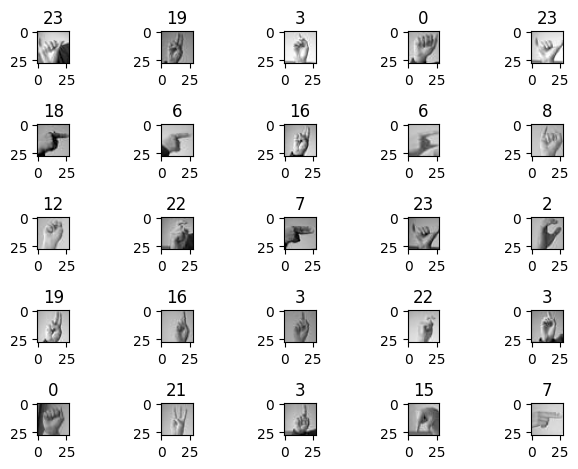

In [ ]:
fig = plt.figure()

for i in range(25):
  random_num = randint(0, 27455)
  fig.add_subplot(5, 5, i + 1)
  plt.imshow(train_folder[random_num][0].detach().numpy().transpose((1, 2, 0)))
  plt.title(int(train_folder[random_num][1]))

fig.tight_layout()

In [ ]:
train_loader = DataLoader(train_folder, batch_size = 25, shuffle = True)
test_loader = DataLoader(test_folder, batch_size = 25, shuffle = True)

## **Deep Learning**

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
torch.manual_seed(42)

In [ ]:
class CNN(nn.Module):

  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(
        in_channels = 3,
        out_channels = 6,
        kernel_size = 3,
        stride = 1,
        padding = 0
    )

    self.max_pool = nn.MaxPool2d(
        kernel_size = 2,
        stride = 2
    )

    self.conv2 = nn.Conv2d(
        in_channels = 6,
        out_channels = 16,
        kernel_size = 3,
        stride = 1,
        padding = 0
    )

    self.flatten = nn.Flatten()

    self.fc_layers = nn.Sequential(
        nn.Linear(in_features = 5 * 5 * 16, out_features = 124),
        nn.Linear(in_features = 124, out_features = 84),
        nn.Linear(in_features = 84, out_features = 64),
        nn.Linear(in_features = 64, out_features = 24)
    )

    self.log_softmax = nn.LogSoftmax(dim = 1)

  def forward(self, x):
    x = self.conv1(x)
    x = self.max_pool(x)
    x = self.conv2(x)
    x = self.max_pool(x)

    x = self.flatten(x)

    x = self.fc_layers(x)
    x = self.log_softmax(x)

    return x

In [ ]:
model = CNN().to(device)
model

CNN(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_layers): Sequential(
    (0): Linear(in_features=400, out_features=124, bias=True)
    (1): Linear(in_features=124, out_features=84, bias=True)
    (2): Linear(in_features=84, out_features=64, bias=True)
    (3): Linear(in_features=64, out_features=24, bias=True)
  )
  (log_softmax): LogSoftmax(dim=1)
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

### **Training**

In [48]:
epochs = 10

training_losses = []
testing_losses = []
training_accuracies = []
testing_accuracies = []

for epoch in range(epochs):

  # Training

  model.train()

  training_correct = 0
  for batch, (x_train, y_train) in enumerate(train_loader):
    x_train, y_train = x_train.to(device), y_train.to(device)

    y_pred = model(x_train)
    loss = loss_fn(y_pred, y_train)

    training_correct += (torch.max(y_pred, 1)[1] == y_train).sum()
    training_losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (batch + 1) % 50 == 0:
      print(f"Epoch : {epoch + 1} | Batch : {batch + 1} | Loss : {loss.item()}")
  training_accuracies.append(training_correct / len(train_folder))

  # Validating

  model.eval()

  with torch.no_grad():
    testing_correct = 0
    for batch, (x_test, y_test) in enumerate(test_loader):
      x_test, y_test = x_test.to(device), y_test.to(device)

      y_pred = model(x_test)
      loss = loss_fn(y_pred, y_test)

      testing_losses.append(loss.item())
      testing_correct += (torch.max(y_pred, 1)[1] == y_test).sum()
      if (batch + 1) % 100 == 0:
        print(f"Epoch : {epoch + 1} | Validation Batch : {batch + 1} | Validation Loss : {loss.item()}")
    testing_accuracies.append(testing_correct / len(test_folder))

  print(f"Epoch : {epoch + 1} | Training Acc : {training_accuracies[-1]} | Validation Acc : {testing_accuracies[-1]}")

Epoch : 1 | Batch : 50 | Loss : 2.938385009765625
Epoch : 1 | Batch : 100 | Loss : 2.327817916870117
Epoch : 1 | Batch : 150 | Loss : 1.8913553953170776
Epoch : 1 | Batch : 200 | Loss : 1.3489439487457275
Epoch : 1 | Batch : 250 | Loss : 1.4787721633911133
Epoch : 1 | Batch : 300 | Loss : 0.6935885548591614
Epoch : 1 | Batch : 350 | Loss : 1.167173981666565
Epoch : 1 | Batch : 400 | Loss : 0.4880776107311249
Epoch : 1 | Batch : 450 | Loss : 0.7259024977684021
Epoch : 1 | Batch : 500 | Loss : 0.9524232745170593
Epoch : 1 | Batch : 550 | Loss : 0.46051907539367676
Epoch : 1 | Batch : 600 | Loss : 0.6257975101470947
Epoch : 1 | Batch : 650 | Loss : 0.26724743843078613
Epoch : 1 | Batch : 700 | Loss : 0.9586805701255798
Epoch : 1 | Batch : 750 | Loss : 0.46651017665863037
Epoch : 1 | Batch : 800 | Loss : 0.33523324131965637
Epoch : 1 | Batch : 850 | Loss : 0.2505912482738495
Epoch : 1 | Batch : 900 | Loss : 0.42732420563697815
Epoch : 1 | Batch : 950 | Loss : 0.2824701964855194
Epoch : 1 |

### **Plotting & Evaluating**

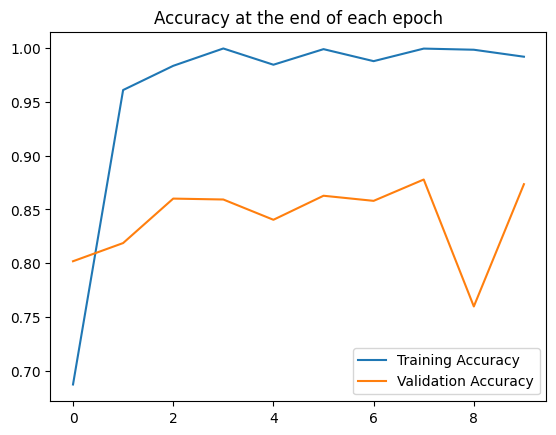

In [79]:
plt.plot([t.cpu() for t in training_accuracies], label = "Training Accuracy")
plt.plot([t.cpu() for t in testing_accuracies], label = "Validation Accuracy")
plt.title("Accuracy at the end of each epoch")
plt.legend()

In [51]:
model.eval()

correct = 0
y_testing = []
y_predicted = []

with torch.no_grad():
  for _, (x_test, y_test) in enumerate(test_loader):
    x_test, y_test = x_test.to(device), y_test.to(device)
    y_pred = torch.max(model(x_test), 1)[1]
    correct += (y_pred == y_test).sum()

    for i, j in zip(y_pred, y_test):
      y_predicted.append(i.cpu())
      y_testing.append(j.cpu())

print(f"Accuracy : {correct / len(test_folder) * 100} %")

Accuracy : 87.33966064453125 %


In [52]:
from sklearn.metrics import classification_report
print(classification_report(y_pred = y_predicted, y_true = y_testing))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       331
           1       0.95      0.87      0.91       432
           2       0.99      1.00      1.00       310
           3       0.94      0.92      0.93       245
           4       0.94      0.99      0.96       498
           5       0.93      1.00      0.96       247
           6       0.77      0.94      0.85       348
           7       0.95      0.95      0.95       436
           8       0.92      0.85      0.89       288
           9       0.89      0.89      0.89       331
          10       0.90      0.90      0.90       209
          11       0.87      0.80      0.83       394
          12       1.00      0.73      0.84       291
          13       1.00      0.77      0.87       246
          14       0.96      0.94      0.95       347
          15       0.86      1.00      0.93       164
          16       0.41      0.57      0.48       144
          17       0.64    

In [60]:
classes = [chr(65 + letter) for letter in range(25) if letter != 9]
classes

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y']

In [73]:
model.eval()

fig = plt.figure(figsize = (100, 100))
fig.tight_layout()

for i in range(25):
  fig.add_subplot(5, 5, i + 1)
  random_num = randint(0, 7000)

  plt.imshow(test_folder[random_num][0].detach().numpy().transpose(1, 2, 0))

  with torch.no_grad():
    pred = model(test_folder[random_num][0].view(1, 3, 28, 28).to(device))
    pred = torch.max(pred, 1)[1]

  plt.title(f"True Label : {classes[test_folder[random_num][1]]} \nPredicted Label : {classes[pred]}", fontdict = {"fontsize" : 50})

## **Saving**

In [53]:
torch.save(model.state_dict(), "HandGesture_CNN.pt")